<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/RunTime_saving_Fitabase_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from glob import glob
import os
import pandas as pd
path = "/content/drive/MyDrive/Iqram Sir/Fitabase data pulls - seperate"

#Function

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

def get_content(patient_folder_adrs):

  post_adrs = sorted(glob(patient_folder_adrs+"/*"))[0]
  

  pre_adrs = sorted(glob(patient_folder_adrs+"/*"))[1]

  for i in glob(post_adrs+"/*"):
    content = i.split("_")
    if "1min" in content:
      post_1min = i
    if "minuteCaloriesNarrow" in content:
      post_cal = i
    if "minuteMETsNarrow" in content:
      post_met = i


  for i in glob(pre_adrs+"/*"):
    content = i.split("_")
    if "1min" in i.split("_"):
      pre_1min = i
    if "minuteCaloriesNarrow" in content:
      pre_cal = i
    if "minuteMETsNarrow" in content:
      pre_met = i
 
  return post_1min, post_cal,post_met, pre_1min, pre_cal, pre_met




def plot(dataFrame,hr_aee = False):
  Y = dataFrame["HR(BPM)"].values.reshape(-1, 1)
  X = dataFrame["aEE(kJ/min)"].values.reshape(-1, 1)
  reg = LinearRegression().fit(X, Y)
  m = reg.coef_[0]
  c = reg.intercept_
  
  fig = plt.figure(figsize=(13,8))
  ax = fig.add_subplot()
  fig.subplots_adjust(top=0.85)

  # Set titles for the figure and the subplot respectively
  #fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
  if hr_aee == True:
    ax.set_title('Max HR & aEE',fontweight='bold')
  else:
    ax.set_title('Max HR',fontweight='bold')

  ax.scatter(X, Y)

  high_y = Y.max()

  high_x = (high_y-c)/m

  rang_y=[Y.min(),high_y]

  ax.plot((rang_y-c)/m, rang_y, color = "red")

  ax.scatter(high_x, high_y, color='green')
  ax.annotate('(aEEMax,HRMax)', xy=(high_x, high_y), xytext=(high_x-5, high_y+10),fontweight='bold')
  ax.annotate("("+str(round(high_x[0],2))+","+str(high_y)+")", xy=(high_x, high_y), xytext=(high_x-3, high_y+5),fontweight='bold',color = 'purple')


  if hr_aee == True:
    ax.set_xlabel("aEE_MAX(kJ/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR_MAX(BPM)",fontweight='bold',fontsize=12)
  else:
    ax.set_xlabel("aEE(kJ/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR(BPM)",fontweight='bold',fontsize=12)

  ax.axis([0, high_x+10, 0, high_y+30])

  ax.grid()
  plt.show()




def signle_sample(df_1min, df_cal,df_met):
  list_1 = list(df_1min["Time"])
  list_2 = list(df_cal["ActivityMinute"])
  #df_met = mets_minute_refine(df_met,min)
  list_3 = list(df_met["ActivityMinute"])


  hr = []
  aee = []
  time = []
  mets = []

  if len(list_1)>len(list_2):
    for i in tqdm(list_1):
      if i in list_2 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  else:
    for i in tqdm(list_2):
      if i in list_1 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  d={
    "Time" : time,
     "HR(BPM)" : hr,
     "aEE(kJ/min)":aee,
     "METs" : mets
  }

  dataFrame = pd.DataFrame.from_dict(d)
  return dataFrame



def max_hr_aee(dataFrame):
  try: 
    Y = dataFrame["HR(BPM)"].values.reshape(-1, 1)
    X = dataFrame["aEE(kJ/min)"].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    m = reg.coef_[0]
    c = reg.intercept_
    hr_mx = Y.max()
    aee_mx = (hr_mx-c)/m
    return hr_mx, round(aee_mx[0],2)
  except ValueError as err:
    print("ERORR: ",err)
    return None,None



def test_signle_sample(data,df_1min,df_cal,df_met):
  total_row = data.shape[0]
  print("Total DataRow: ",total_row)

  err_row=[]

  for i in tqdm(range(total_row)):
    print(data["Time"][i], data['HR(BPM)'][i],round(data['aEE(kJ/min)'][i],2),data['METs'][i])

    hr = list(df_1min.query("Time == '"+data["Time"][i]+"'")['Value'])[0]
    cal = round(list(df_cal.query("ActivityMinute == '"+data["Time"][i]+"'")['Calories'])[0],2)
    mets = list(df_met.query("ActivityMinute == '"+data["Time"][i]+"'")['METs'])[0]
    print(hr,round(cal*4.184,2),mets)
    print("------------------------------------------------------------")

    if hr != data['HR(BPM)'][i] or cal != round(data['aEE(kJ/min)'][i]/4.184,2) or mets != data['METs'][i]:
      err_row.append((data["Time"][i],i))
  return err_row







def range_list(k):
  list_of = []
  main_list = []

  for i in range(len(k)-1):
 
    if k[i+1]-k[i] == 1:
      list_of.append(k[i])
    else:
      list_of.append(k[i])
      main_list.append(list_of)
      list_of=[]
    if i == len(k)-2:
      if k[i+1]-k[i] == 1:
        list_of.append(k[i+1])
        main_list.append(list_of)
      else:
        main_list.append([k[i+1]])
  
  return main_list






def mets_minute_refine(data,minutes,upper_lim,lower_lim):

  mets_none = []
  mets_more = []
  for i in range(data.shape[0]):

    if lower_lim< data["METs"][i] <= upper_lim:
    #if data["METs"][i] > 10:
      mets_more.append(i)
    else:
      mets_none.append(i)

  main_l = range_list(mets_more)

  removable_list = []
  for i in range(len(main_l)-1):
    if len(main_l[i]) < minutes+1:
      for j in main_l[i]:
        removable_list.append(j)

  df1=data.drop(data.index[mets_none+removable_list]).reset_index()
  return df1





from datetime import datetime

def formate24(t):
  time = t.split(" ")
  m2 = time[1]+" "+time[2]
  in_time = datetime.strptime(m2, "%I:%M:%S %p")
  out_time = datetime.strftime(in_time, "%H:%M:%S")
  return out_time


def dif_min(start_time, end_time):
  t1 = datetime.strptime(start_time, "%H:%M:%S")
  t2 = datetime.strptime(end_time, "%H:%M:%S")

  delta = t2 - t1

  return delta.total_seconds()/60







def time_limit_check(test_data,min_limit):
  time_diff_list = []
  let = range_list(list(test_data['index']))
  for i in tqdm(let):

    start_time = formate24(list(test_data.query("index == "+str(i[0])+"")['Time'])[0])
    end_time = formate24(list(test_data.query("index == "+str(i[-1])+"")['Time'])[0])
    diff = dif_min(start_time,end_time)
    if diff < min_limit:
      time_diff_list.append(i)
  
  return time_diff_list


def single_segment_refine(single_list,min_limit):
  temp = []
  main = []
  if len(single_list)>1:
    for i in range(len(single_list)-1):
      k = formate24(list(test_data.query("index == "+str(single_list[i+1])+"")['Time'])[0])
      l = formate24(list(test_data.query("index == "+str(single_list[i])+"")['Time'])[0])
      diff = dif_min(l,k)
      #print(k,l,diff)
      if diff == 1 or diff == -1439.0:
        temp.append(single_list[i])
        flage = 1
      else:
        temp.append(single_list[i])
        if len(temp) >= min_limit+1:
          main.append(temp)
        temp=[]
        flage = 0

    if flage == 1:
      if len(temp) >= min_limit+1:
        k = formate24(list(test_data.query("index == "+str(single_list[i+1])+"")['Time'])[0])
        l = formate24(list(test_data.query("index == "+str(single_list[i])+"")['Time'])[0])
        diff = dif_min(l,k)
        if diff == 1 or diff == -1439.0:
          temp.append(single_list[i+1])
          main.append(temp)
        else:
          main.append(temp)


  return main


def final_refination(data,min_lim):
  print("Time Limit Checking:")
  time_diff_list = time_limit_check(data,min_lim)
  print()

  removeable_list=[]

  print("Unwanted index list making:")
  for i in tqdm(time_diff_list):
  # print(i)
    lis = single_segment_refine(i,min_lim)
    combined = []

    for j in lis:
      combined=combined+j


    for k in i:
      if k not in combined:
        removeable_list.append(k)
  

  print()
  print("Refining Dataset:")

  for i in tqdm(removeable_list):
    data.drop(data.loc[data['index']==i].index, inplace=True)

  data.reset_index()

  return data
#-------------------------------------------------------------------------------


def range_list_time(k):
  list_of = []
  main_list = []

  for i in range(len(k)-1):
    if dif_min(formate24(k[i]),formate24(k[i+1])) == 0:
      continue
    if dif_min(formate24(k[i]),formate24(k[i+1])) == 1:
      list_of.append(k[i])
    else:
      list_of.append(k[i])
      main_list.append(list_of)
      list_of=[]
    if i == len(k)-2:
      if dif_min(formate24(k[i]),formate24(k[i+1])) == 1:
        list_of.append(k[i+1])
        main_list.append(list_of)
      else:
        main_list.append([k[i+1]])

  return main_list


#Sample Test for single subject

In [9]:
subject = '001-JV'



for i in glob(path+"/*"):
  #get_contenct(i)
  if subject in i.split("/"):
    Post_1min,Post_cal,Post_met, Pre_1min,Pre_cal,Pre_met = get_content(i)

df_post_1min = pd.read_csv(Post_1min)
df_post_cal = pd.read_csv(Post_cal)
df_post_met = pd.read_csv(Post_met)

df_pre_1min = pd.read_csv(Pre_1min)
df_pre_cal = pd.read_csv(Pre_cal)
df_pre_met = pd.read_csv(Pre_met)



In [11]:
d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)

  0%|          | 0/80640 [00:00<?, ?it/s]

In [12]:
d.head()

,Time,HR(BPM),aEE(kJ/min),METs
0,12/7/2021 3:52:00 PM,69,6.719337,12
1,12/7/2021 3:53:00 PM,64,5.599447,10
2,12/7/2021 3:54:00 PM,65,5.599447,10
3,12/7/2021 3:57:00 PM,70,6.159392,11
4,12/7/2021 4:05:00 PM,70,15.678452,28


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def drw(x,y):
  plt.figure(figsize = (25,10))
  plt.plot(x,y)
  plt.xlabel('TIME')
  plt.ylabel ('METs')

In [14]:
met_list = list(d['METs'])

tr = range_list_time(list(d['Time']))


In [ ]:
tr[3]

In [22]:

time = []
mets = []
for i in tr[3]:
  time.append(i)
  mets.append(list(d.query("Time == '"+i+"'")['METs'])[0])

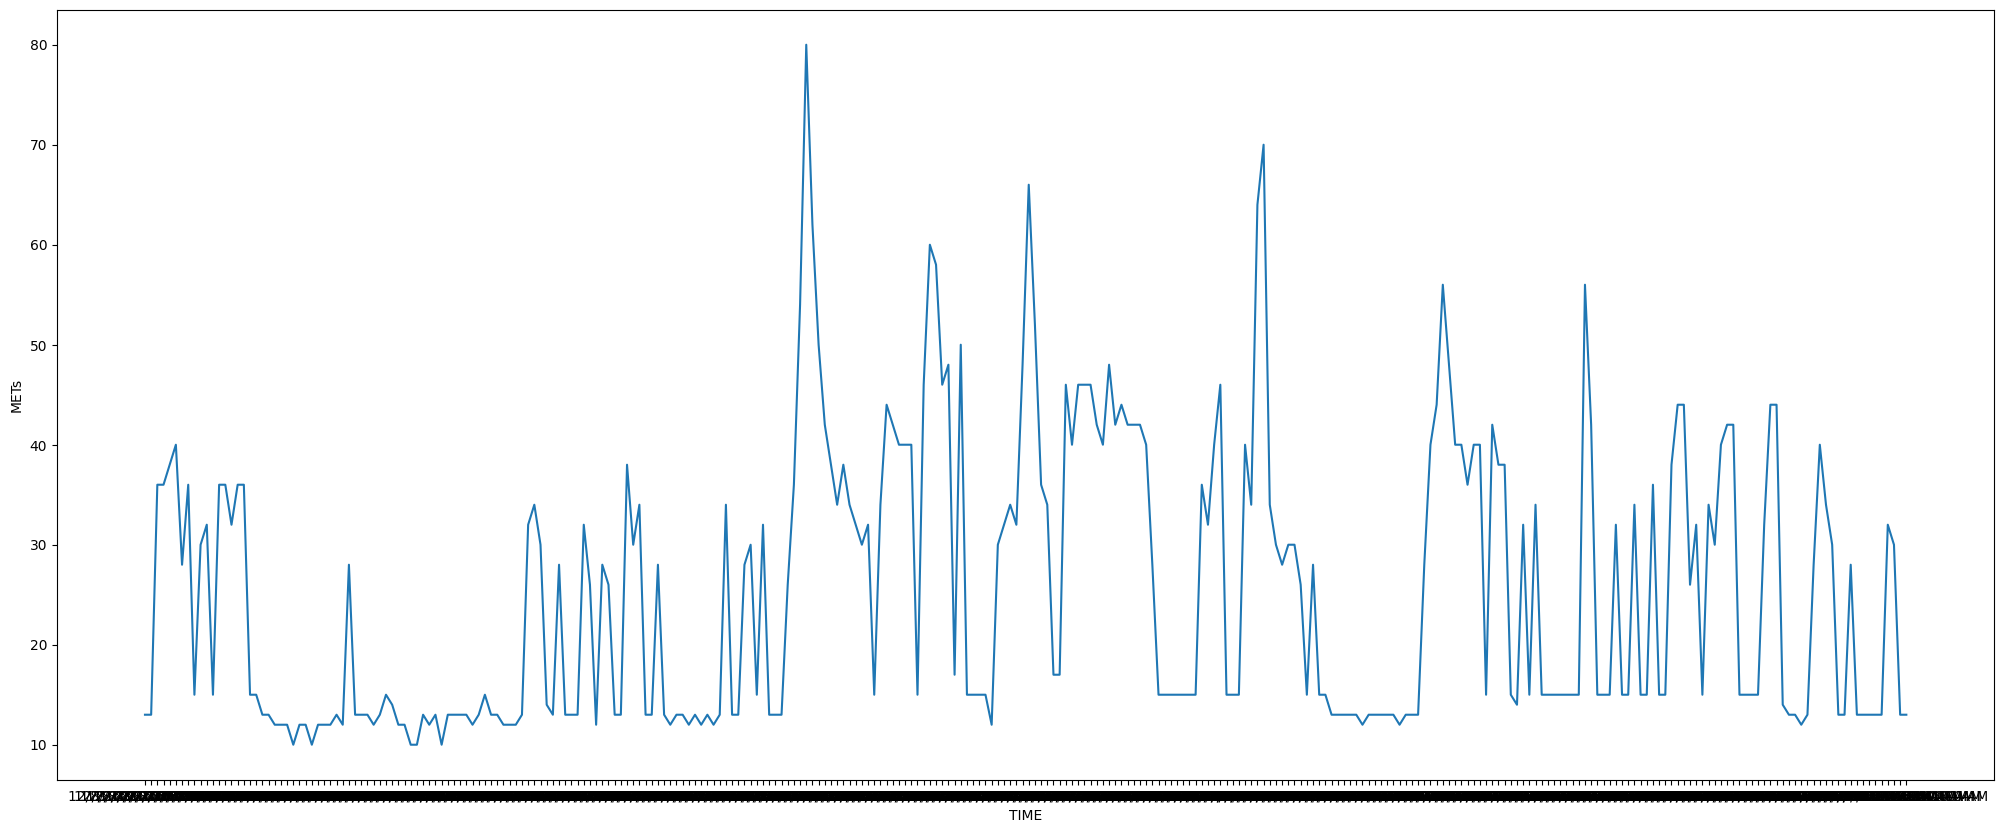

In [23]:
drw(time,mets)

In [17]:
for i in tr:
  print(len(i))

3
1
1
286
187
547
412
605
10
52
11
108
91
394
1
2
14
198
180
245
166
383
30
455
67
10
216
407
19
88
73
184
172
206
58
387
390
99
59
64
329
274
132
4
2
3
3
3
9
2
2
2
48
34
32
261
39
6
525
19
79
86
193
350
12
55
42
67
110
43
82
23
103
94
7
19
13
30
82
141
95
14
10
98
144
13
42
17
79
2
23
62
63
22
154
2
28
134
60
51
2
2
10
204
91
196
15
271
111
69
144
267
78
110
102
138
44
20
252
37
102
61
81
399
18
191
91
7
69
44
40
90
98
3
102
79
134
18
66
176
196
273
286
92
51
84
241
299
244
6
33
105
45
381
108
1
9
52
18
409
231
337
39
159
180
193
102
209
138
186
92
66
104
22
105
143
507
50
104
387
18
42
292
6
14
406
27
80
360
666
1
225
658
397
612
4
1
1
2
4
1
693
482
531
74
337
178
277
6
324
82
292
263
374
122
27
11
227
24
13
35
18
21
71
145
3
21
318
67
312
42
8
102
285
250
11
92
49
35
9
28
21
154
221
119
12
132
186
296
25
198
85
225
116
279
502
16
11
221
73
46
408
138
30
384
108
226
161
137
376
91
28
409
29
551
18
49
110
553
44
13
1
385
151
211
62
307
146
29
31
85
102
5
96
8
5
3
2


##Pre Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `pre condition`.<br>


In [ ]:
d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)

  0%|          | 0/80640 [00:00<?, ?it/s]

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "25 \u003C METs \u003C= 45" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 20
  lower_lim = 10
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 40
  lower_lim = 20
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 40
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 25 < METs <= 45
Upper Limit:  45
Lower Limit:  25
Activity:  Moderate_Activity


###Refining

In [ ]:
epoch = 15      #set the epoch number

test_data = mets_minute_refine(d, epoch,upper_lim,lower_lim)
final_data = final_refination(test_data,epoch)
#final_data.to_csv(subject+"_"+"pre"+"_"+activity+".csv",index=False)

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
final_data.shape

(18, 5)

###Ploting

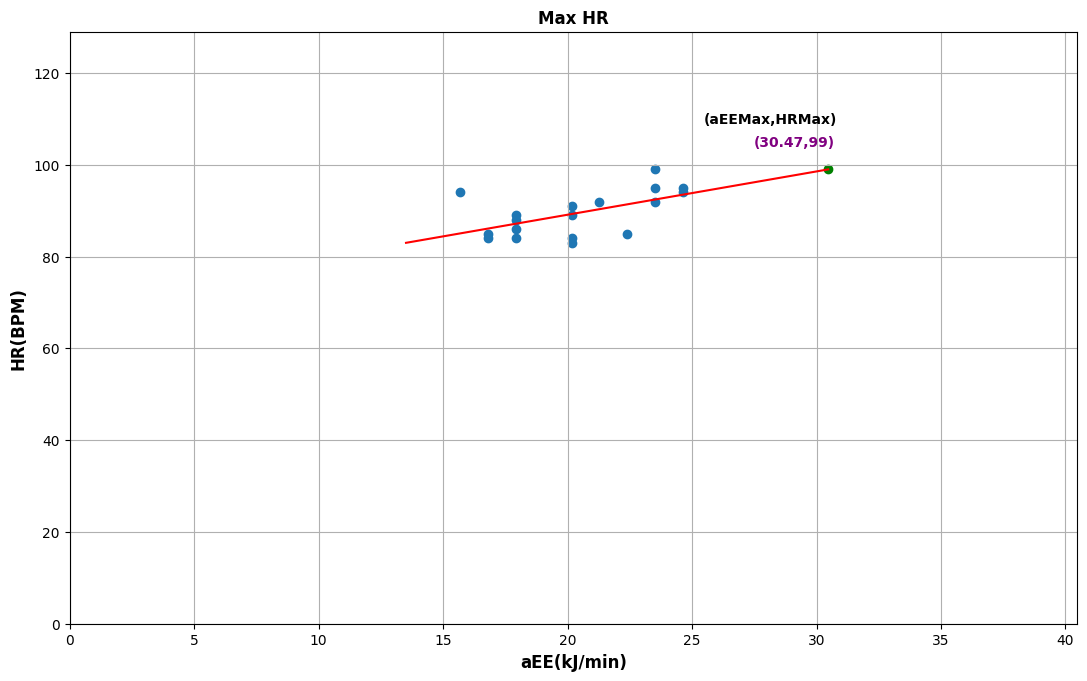

In [ ]:
plot(final_data)

In [ ]:
max_hr_aee(final_data)

(99, 30.47)

##Post Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `post condition`.<br>


In [ ]:
d2 = signle_sample(df_post_1min,df_post_cal,df_post_met)

  0%|          | 0/50400 [00:00<?, ?it/s]

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "25 \u003C METs \u003C= 45" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 45
  lower_lim = 25
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 45
  lower_lim = 25
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 45
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 25 < METs <= 45
Upper Limit:  45
Lower Limit:  25
Activity:  Moderate_Activity


###Refining

In [ ]:
epoch = 15        #set the epoch number

test_data = mets_minute_refine(d2, epoch,upper_lim,lower_lim)
final_data = final_refination(test_data,epoch)
#final_data.to_csv(subject+"_"+"post"+"_"+activity+".csv",index=False)

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/3 [00:00<?, ?it/s]

###Ploting

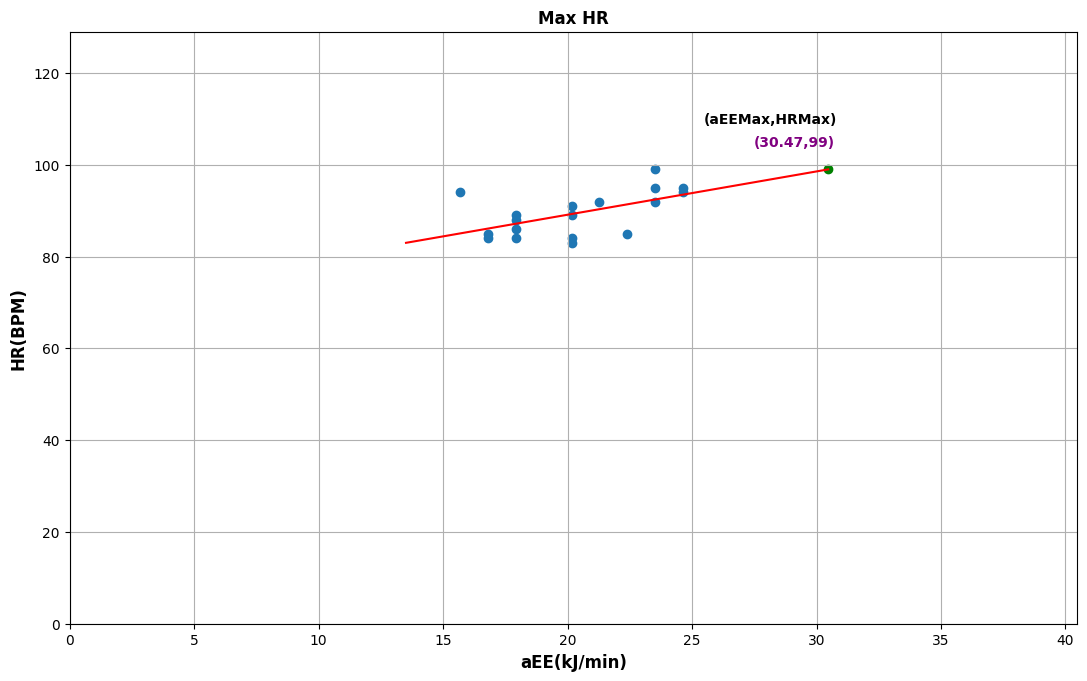

In [ ]:
plot(final_data)

In [ ]:
max_hr_aee(final_data)

(99, 30.47)

#Dataset Creation with all `HR_MAX` and `aEE_MAX` values of all patients.

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "45 \u003C METs \u003C=60" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 45
  lower_lim = 25
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 45
  lower_lim = 25
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 45
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 45 < METs <=60
Upper Limit:  60
Lower Limit:  45
Activity:  Heavy_Activity


In [ ]:
file_save_destination = '/content/drive/MyDrive/Iqram Sir/FInal_Ftiabase_HR_aEE_MAX/'+activity+'_HR_aEE_MAX.csv'

In [ ]:

epoch = 15


if os.path.exists(file_save_destination)==False:
  main_dict = {
      "Patient_Id" : [],
      "Condition" : [],
      "HR_MAX(BPM)" : [],
      "aEE_MAX(kJ/min)": []
  }

  df = pd.DataFrame.from_dict(main_dict)
  df.to_csv(file_save_destination,index=False)



p_id = []
condition = []
hr_max = []
aee_max = []

for i in tqdm(sorted(glob(path+"/*"))):
  test_dataset = pd.read_csv(file_save_destination)
  print()
  print()
  sub =  os.path.basename(i)
  print("Subject processing: ",sub)
  Post_1min, Post_cal,Post_met, Pre_1min, Pre_cal,Pre_met = get_content(i)

  if 'pre' not in list(test_dataset.query("Patient_Id == '"+sub+"'")['Condition']):
    p_id.append(sub)
    condition.append('pre')
    df_pre_1min = pd.read_csv(Pre_1min)
    df_pre_cal = pd.read_csv(Pre_cal)
    df_pre_met = pd.read_csv(Pre_met)
    print("Pre Condition In Process:")
    d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)
    test_data = mets_minute_refine(d, epoch,upper_lim,lower_lim)
    final_data = final_refination(test_data,epoch)
    h,a = max_hr_aee(final_data)
    hr_max.append(h)
    aee_max.append(a)

    temp_dict = {
    "Patient_Id" : [sub],
    "Condition" : ['pre'],
    "HR_MAX(BPM)" : [h],
    "aEE_MAX(kJ/min)": [a]
    }
    temp_df = pd.DataFrame(temp_dict)
    temp_df.to_csv(file_save_destination, mode='a', index=False, header=False)
    print("Pre Condition Process Complete...")


  if 'post' not in list(test_dataset.query("Patient_Id == '"+sub+"'")['Condition']):
    p_id.append(sub)
    condition.append('post')
    df_post_1min = pd.read_csv(Post_1min)
    df_post_cal = pd.read_csv(Post_cal)
    df_post_met = pd.read_csv(Post_met)
    print("Post Condition In Process:")
    d2 = signle_sample(df_post_1min,df_post_cal,df_post_met)
    test_data = mets_minute_refine(d2, epoch,upper_lim,lower_lim)
    final_data = final_refination(test_data,epoch)
    h,a = max_hr_aee(final_data)
    hr_max.append(h)
    aee_max.append(a)
    print("Post Condition Process Complete...")
    print()

  
    temp_dict = {
    "Patient_Id" : [sub],
    "Condition" : ['post'],
    "HR_MAX(BPM)" : [h],
    "aEE_MAX(kJ/min)": [a]
    }
    temp_df = pd.DataFrame(temp_dict)
    temp_df.to_csv(file_save_destination, mode='a', index=False, header=False)
  print(sub," Processing Complete.....")
  print("------------------------------------------------------------------------")


print("Dataset creation complete......")

  0%|          | 0/36 [00:00<?, ?it/s]



Subject processing:  001-JV
Pre Condition In Process:


  0%|          | 0/80640 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


  0%|          | 0/50400 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

001-JV  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  002-JR


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/41760 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

002-JR  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  003-ES


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/14400 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/5 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/5 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/3 [00:00<?, ?it/s]

Post Condition Process Complete...

003-ES  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  004-LY
Pre Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/43200 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Post Condition Process Complete...

004-LY  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  005-DF
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/47075 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Post Condition Process Complete...

005-DF  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  006-MK
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

006-MK  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  007-DD


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/12960 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

007-DD  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  008-KL


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

008-KL  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  010-ML


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/41760 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


  0%|          | 0/46827 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

010-ML  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  011-CR
Pre Condition In Process:


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/4 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

011-CR  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  012-DP
Pre Condition In Process:


  0%|          | 0/11520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/53280 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

012-DP  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  013-MB
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/53280 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/4 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

013-MB  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  014-WK
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/3 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Post Condition Process Complete...

014-WK  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  015-BL
Pre Condition In Process:


  0%|          | 0/17280 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/4 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/3 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

015-BL  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  016-JN
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

016-JN  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  018-PDT


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

018-PDT  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  019-CM
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]